In [1]:
import numpy as np
import cv2
import sklearn
from matplotlib import pyplot as plt
from shutil import copyfile
import shutil
import random
%matplotlib inline

In [2]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

2021-12-12 18:11:25.820783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/site-packages/cv2/../../../../lib:
2021-12-12 18:11:25.820860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [4]:
from os import listdir, mkdir, getcwd
from os.path import isfile, join

In [5]:
getcwd()

'/spaceapps_test'

# Importing dataset paths

In [6]:
labels_path = "data/ai4mars-dataset-merged-0.1/msl/labels/train/"
imgs_path = "data/ai4mars-dataset-merged-0.1/msl/images/edr/"

labels_files = [f for f in listdir(labels_path) if isfile(join(labels_path, f))]
imgs_files = [f for f in listdir(imgs_path) if isfile(join(imgs_path, f))]

# Understanding dataset

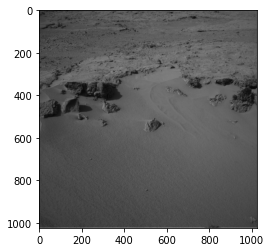

In [7]:
img = cv2.imread(imgs_path+"NLA_402736827EDR_F0050104NCAM00449M1.JPG")
plt.imshow(img)

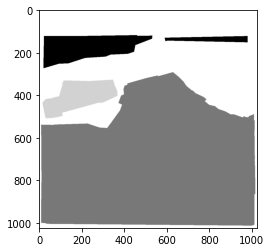

In [8]:
labels = cv2.imread(labels_path+"NLA_402736827EDR_F0050104NCAM00449M1.png")
labels[labels==0] = 0   #soil labels remain black
labels[labels==1] = 50  #bedrock labels in dark grey
labels[labels==2] = 120 #sand labels in light grey
labels[labels==3] = 210 #big_rock labels in broken white

plt.imshow(labels)

# Selecting images and cleaning labels with big rocks[3]

I will select a subset of images where big_rocks appear and another one where they don't appear. In this way, I will be able to create balanced datasets for training and testing.

I will label the background as 0 and the big_rocks as 1.

I will save the original images normalized to the [0,1] range.

In [9]:
len(labels_files)

16064

In [10]:
max_images = 200
label_id = 3
imgs_contain_rocks = []
labels_contain_rocks = []
imgs_contain_no_rocks = []
labels_contain_no_rocks = []

labels_only_rocks = "data/ai4mars-dataset-merged-0.1/msl/labels/only_rocks/"
imgs_only_rocks = "data/ai4mars-dataset-merged-0.1/msl/images/only_rocks/"

#randomly shuffled image names to make sure there is no order dependency
random.shuffle(labels_files)

count = 0
print(getcwd())
try:
    mkdir(labels_only_rocks)
except:
    print("Folder already exists")
    max_images = 0
    count = len(labels_files)
try:
    mkdir(imgs_only_rocks)
except:
    print("Folder already exists")
    max_images = 0
    count = len(labels_files)

while (len(imgs_contain_rocks) < max_images or len(imgs_contain_no_rocks) < max_images) and count < len(labels_files)-1:
    label_name = labels_files[count]
    labels = cv2.imread(labels_path+label_name)
    count += 1
    
    if label_id in np.unique(labels):
        if len(imgs_contain_rocks) < max_images:
            labels[labels!=label_id] = 255
            labels[labels==label_id] = 1
            labels[labels!=label_id] = 0
            imgs_contain_rocks.append(imgs_only_rocks+label_name[:-4]+".JPG")
            labels_contain_rocks.append(labels_only_rocks+label_name)

            cv2.imwrite(labels_only_rocks+label_name, labels)
            copyfile(imgs_path+label_name[:-4]+".JPG", imgs_only_rocks+label_name[:-4]+".JPG")

    elif len(imgs_contain_no_rocks) < max_images:
        labels[labels!=label_id] = 0
        imgs_contain_no_rocks.append(imgs_only_rocks+label_name[:-4]+".JPG")
        labels_contain_no_rocks.append(labels_only_rocks+label_name)

        cv2.imwrite(labels_only_rocks+label_name, labels)
        copyfile(imgs_path+label_name[:-4]+".JPG", imgs_only_rocks+label_name[:-4]+".JPG")
    print("num_rocks: ", len(imgs_contain_rocks), "num_no_rocks", len(imgs_contain_no_rocks))

if max_images > 0:
    with open('src/contain_rocks/imgs_contain_no_rocks.txt', 'w') as f:
        for item in imgs_contain_no_rocks:
            f.write("%s\n" % item)

    with open('src/contain_rocks/labels_contain_no_rocks.txt', 'w') as f:
        for item in labels_contain_no_rocks:
            f.write("%s\n" % item)
        

    with open('src/contain_rocks/imgs_contain_rocks.txt', 'w') as f:
        for item in imgs_contain_rocks:
            f.write("%s\n" % item)

    with open('src/contain_rocks/labels_contain_rocks.txt', 'w') as f:
        for item in labels_contain_rocks:
            f.write("%s\n" % item)

/spaceapps_test
Folder already exists
Folder already exists


In [11]:
getcwd()



'/spaceapps_test'

In [12]:
# shutil.rmtree(labels_only_rocks)
# shutil.rmtree(imgs_only_rocks)


# Splitting data into train, validation and test datasets

In [13]:
def split_dataset(num_imgs_rocks, num_imgs_no_rocks,split=0.6):
    imgs_contain_rocks = np.loadtxt('src/contain_rocks/imgs_contain_rocks.txt', dtype=str)
    labels_contain_rocks = np.loadtxt('src/contain_rocks/labels_contain_rocks.txt', dtype=str)
    labels_contain_no_rocks = np.loadtxt('src/contain_rocks/labels_contain_no_rocks.txt', dtype=str)
    imgs_contain_no_rocks = np.loadtxt('src/contain_rocks/imgs_contain_no_rocks.txt', dtype=str)

    num_rock_images_train = int(num_imgs_rocks * split)
    num_no_rock_images_train = int(num_imgs_no_rocks * split)

    indexes_rocks_train = random.sample(range(0, num_imgs_rocks), num_rock_images_train)
    indexes_rocks_no_train = np.setxor1d(range(0,num_imgs_rocks), indexes_rocks_train)
    indexes_rocks_validation = indexes_rocks_no_train[random.sample(range(0,len(indexes_rocks_no_train)), len(indexes_rocks_no_train)//2)]
    indexes_rocks_test = np.setxor1d(indexes_rocks_no_train, indexes_rocks_validation)

    indexes_no_rocks_train = random.sample(range(0, num_imgs_no_rocks), num_rock_images_train)
    indexes_no_rocks_no_train = np.setxor1d(range(0,num_imgs_no_rocks), indexes_no_rocks_train)
    indexes_no_rocks_validation = indexes_no_rocks_no_train[random.sample(range(0,len(indexes_no_rocks_no_train)), len(indexes_no_rocks_no_train)//2)]
    indexes_no_rocks_test = np.setxor1d(indexes_no_rocks_no_train, indexes_no_rocks_validation)

    imgs_paths_train = np.concatenate((imgs_contain_rocks[indexes_rocks_train], imgs_contain_no_rocks[indexes_no_rocks_train]))
    labels_paths_train = np.concatenate((labels_contain_rocks[indexes_rocks_train], labels_contain_no_rocks[indexes_no_rocks_train]))
    imgs_paths_test = np.concatenate((imgs_contain_rocks[indexes_rocks_test], imgs_contain_no_rocks[indexes_no_rocks_test]))
    labels_paths_test = np.concatenate((labels_contain_rocks[indexes_rocks_test], labels_contain_no_rocks[indexes_no_rocks_test]))
    imgs_paths_validation = np.concatenate((imgs_contain_rocks[indexes_rocks_validation], imgs_contain_no_rocks[indexes_no_rocks_validation]))
    labels_paths_validation = np.concatenate((labels_contain_rocks[indexes_rocks_validation], labels_contain_no_rocks[indexes_no_rocks_validation]))

    return imgs_paths_train, labels_paths_train, imgs_paths_test, labels_paths_test, imgs_paths_validation, labels_paths_validation

In [14]:
def load_imgs_from_indexes_tensors(imgs_paths, labels_paths):
    imgs_tensor_out = tf.zeros([1024, 1024, 3],dtype=tf.dtypes.uint8)
    labels_tensor_out = tf.zeros([1024, 1024, 3],dtype=tf.dtypes.uint8)
    count = 0
    for indx in random.sample(range(0, len(imgs_paths)), len(imgs_paths)):

        img_path = imgs_paths[indx]
        labels_path = labels_paths[indx]

        img = cv2.imread(img_path)
        labels = cv2.imread(labels_path)
        img_tensor = tf.convert_to_tensor(img)
        labels_tensor = tf.convert_to_tensor(labels)

        if count == 0:
            imgs_tensor_out = img_tensor
            labels_tensor_out = labels_tensor
        else:
            imgs_tensor_out = tf.stack([imgs_tensor_out,img_tensor],0)
            labels_tensor_out = tf.stack([labels_tensor_out,labels_tensor],0)

        count += 1
        
    return imgs_tensor_out, labels_tensor_out

In [15]:
def load_imgs_from_indexes(imgs_paths, labels_paths):
    imgs_list = []
    labels_list = []
    for indx in random.sample(range(0, len(imgs_paths)), len(imgs_paths)):
        img_path = imgs_paths[indx]
        labels_path = labels_paths[indx]

        img = cv2.imread(img_path)#cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
        labels = cv2.imread(labels_path)[:,:,0]
        imgs_list.append(img)
        labels_list.append(labels)
    return imgs_list, labels_list

In [16]:
def load_data(split=0.6):
    imgs_contain_rocks = np.loadtxt('src/contain_rocks/imgs_contain_rocks.txt', dtype=str)
    labels_contain_rocks = np.loadtxt('src/contain_rocks/labels_contain_rocks.txt', dtype=str)
    labels_contain_no_rocks = np.loadtxt('src/contain_rocks/labels_contain_no_rocks.txt', dtype=str)
    imgs_contain_no_rocks = np.loadtxt('src/contain_rocks/imgs_contain_no_rocks.txt', dtype=str)

    imgs_paths_train, labels_paths_train, imgs_paths_test, labels_paths_test, imgs_paths_validation, \
        labels_paths_validation = split_dataset(len(imgs_contain_rocks), len(imgs_contain_no_rocks),split=split)
        
    
    #split the data set using the indexes and return 6 np.arrays of loaded images
    x_train, y_train = load_imgs_from_indexes(imgs_paths=imgs_paths_train, labels_paths=labels_paths_train)
    x_test, y_test = load_imgs_from_indexes(imgs_paths=imgs_paths_test, labels_paths=labels_paths_test)
    x_val, y_val = load_imgs_from_indexes(imgs_paths=imgs_paths_validation, labels_paths=labels_paths_validation)

    return x_train, y_train, x_test, y_test, x_val, y_val
    

    
    

# Training model

In [ ]:
#Following this tutorial https://segmentation-models.readthedocs.io/en/latest/tutorial.html
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_test, y_test, x_val, y_val = load_data(split=0.6)

x_train = tf.convert_to_tensor(x_train[:15])
y_train = tf.convert_to_tensor(y_train[:15])
y_train = tf.cast(y_train, tf.float32)

x_test = tf.convert_to_tensor(x_test[:5])
y_test = tf.convert_to_tensor(y_test[:5])
y_test = tf.cast(y_test, tf.float32)

x_val = tf.convert_to_tensor(x_val[:5])
y_val = tf.convert_to_tensor(y_val[:5])
y_val = tf.cast(y_val, tf.float32)

In [17]:
# preprocess input
X_train = preprocess_input(x_train)
X_val = preprocess_input(x_val)

shape = X_train[0].shape
# define model
model = Unet(BACKBONE, encoder_weights='imagenet', classes=1, input_shape=(shape[0], shape[1], shape[2]),encoder_freeze=True, activation='softmax')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# fit model
model.fit(
    x=X_train,
    y=y_train,
    batch_size=2,
    epochs=10,
    validation_data=(X_val, y_val),
)

2021-12-12 18:11:35.527229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/site-packages/cv2/../../../../lib:
2021-12-12 18:11:35.527254: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-12 18:11:35.527279: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-12-12 18:11:35.528193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


2021-12-12 18:12:14.506675: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1207959552 exceeds 10% of free system memory.
2021-12-12 18:12:14.506777: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1207959552 exceeds 10% of free system memory.
2021-12-12 18:12:15.828852: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1207959552 exceeds 10% of free system memory.
2021-12-12 18:12:15.828897: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1207959552 exceeds 10% of free system memory.


1/8 [==>...........................] - ETA: 1:32 - loss: 2.3012 - iou_score: 6.9599e-12

2021-12-12 18:12:23.889734: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1207959552 exceeds 10% of free system memory.


8/8 [==============================] - 82s 10s/step - loss: 1.9252 - iou_score: 9.5523e-12 - val_loss: 1.0336 - val_iou_score: 5.7047e-10
Epoch 2/10
8/8 [==============================] - 80s 10s/step - loss: 1.5641 - iou_score: 1.2835e-11 - val_loss: 1.0006 - val_iou_score: 1.6512e-08
Epoch 3/10
8/8 [==============================] - 80s 10s/step - loss: 1.4147 - iou_score: 1.6225e-11 - val_loss: 1.0002 - val_iou_score: 3.8319e-08
Epoch 4/10
8/8 [==============================] - 80s 10s/step - loss: 1.3125 - iou_score: 2.0653e-11 - val_loss: 1.0014 - val_iou_score: 5.9672e-09
Epoch 5/10
8/8 [==============================] - 80s 10s/step - loss: 1.2357 - iou_score: 2.6230e-11 - val_loss: 1.0060 - val_iou_score: 1.1152e-09
Epoch 6/10
8/8 [==============================] - 80s 10s/step - loss: 1.1777 - iou_score: 3.4095e-11 - val_loss: 1.0153 - val_iou_score: 4.4947e-10
Epoch 7/10
8/8 [==============================] - 80s 10s/step - loss: 1.1337 - iou_score: 4.4091e-11 - val_loss: 1.0

In [21]:
model.save_weights('src/checkpoints2/my_checkpoint')

In [22]:
# Create a new model instance
model2 = Unet(BACKBONE, encoder_weights='imagenet', classes=1, input_shape=(shape[0], shape[1], shape[2]),encoder_freeze=True)
model2.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# Restore the weights
model2.load_weights('src/checkpoints/my_checkpoint')

In [23]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

1/1 - 4s - loss: 1.0981 - iou_score: 2.1172e-11 - 4s/epoch - 4s/step
Restored model, accuracy:  0.00%


In [27]:
y_test

<tf.Tensor: shape=(5, 1024, 1024), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0

In [26]:
model2.predict(x_test)

array([[[[0.39731407],
         [0.33633488],
         [0.3281927 ],
         ...,
         [0.3462484 ],
         [0.31251878],
         [0.39452833]],

        [[0.27575642],
         [0.21163958],
         [0.19485456],
         ...,
         [0.20969284],
         [0.2021898 ],
         [0.33056283]],

        [[0.28638873],
         [0.21399772],
         [0.19185609],
         ...,
         [0.19169116],
         [0.19010428],
         [0.31698653]],

        ...,

        [[0.24095798],
         [0.3226778 ],
         [0.1295197 ],
         ...,
         [0.1976639 ],
         [0.18890187],
         [0.30421382]],

        [[0.25033796],
         [0.30959666],
         [0.16278145],
         ...,
         [0.19431064],
         [0.19325244],
         [0.3049507 ]],

        [[0.1903755 ],
         [0.2361454 ],
         [0.19663355],
         ...,
         [0.26864982],
         [0.26597595],
         [0.37057626]]],


       [[[0.39658952],
         [0.33433318],
         [0.32